<a href="https://colab.research.google.com/github/varunkr24/CNN-Image-Classification-1/blob/Python/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
# import needed libraries
import os as os
from PIL import Image
from array import array
import cv2 as cv2
from glob import glob
import time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from keras.utils import np_utils
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
seed = 7
np.random.seed(seed)

# for API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K


In [6]:
!pip install tflearn

     |████████████████████████████████| 112kB 5.7MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=a37bc50dc2c80680c8218178b08c5d0860c2b354ec1d4e10c97997eda1c9c81a
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [7]:
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(64, 64))

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [9]:
  Y.dtype

dtype('float64')

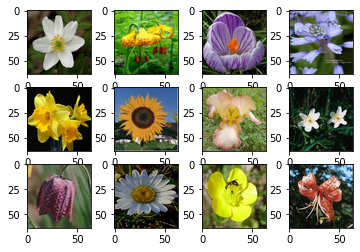

In [10]:
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(X[i])

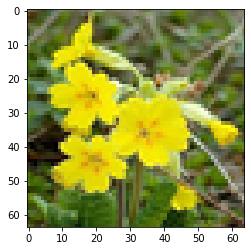

In [11]:
 plt.imshow(X[200])

Label:
7


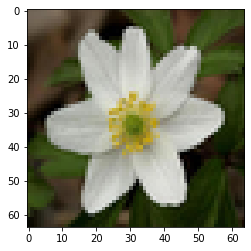

In [12]:
plt.imshow(X[0]);
print('Label:')
print(np.argmax(Y[0]))

Label:
9


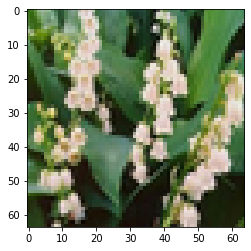

In [13]:
plt.imshow(X[300]);
print('Label:')
print(np.argmax(Y[300]))

(1360, 64, 64, 3)


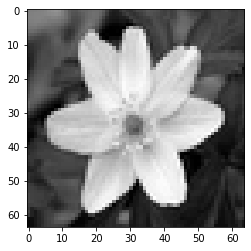

In [14]:
print(X.shape)
plt.imshow(X[0][:,:,0],cmap='gray')

(1360, 64, 64, 3)


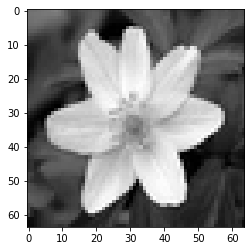

In [16]:
print(X.shape)
plt.imshow(X[0][:,:,1],cmap='gray')

(1360, 64, 64, 3)


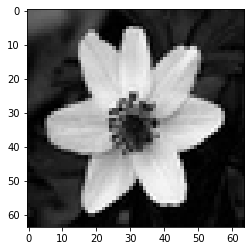

In [17]:
print(X.shape)
plt.imshow(X[0][:,:,2],cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


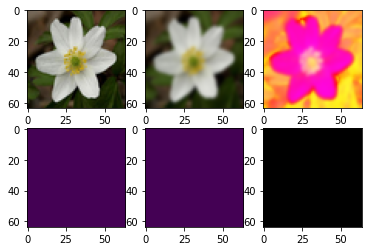

In [20]:
clearTrainImg = []
examples = []; getEx = True
for img in X:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without background
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

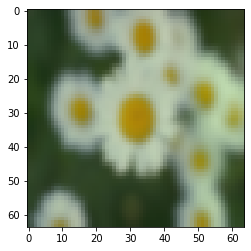

In [27]:
plt.imshow(blurImg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


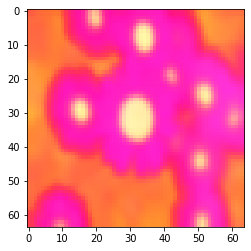

In [28]:
plt.imshow(hsvImg)

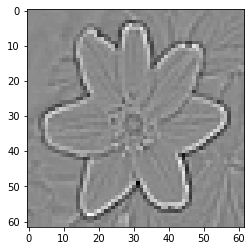

In [25]:
# outline kernel - used for edge detection
kernel = np.array([[-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]])

# we use 'valid' which means we do not add zero padding to our image
edges = convolve2d(X[0][:,:,0], kernel, mode = 'valid')

plt.imshow(edges,cmap='gray')

In [29]:
X.shape, Y.shape

((1360, 64, 64, 3), (1360, 17))

In [30]:
n_samples = len(X)
X_flatten = X.reshape((n_samples, -1))

In [62]:
Y = np.asarray(Y)
Y_label = np.argmax(Y,axis=-1) 

In [65]:
X_flatten.shape, Y_label.shape

((1360, 12288), (1360,))

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_flatten,Y_label)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(1020, 12288), (1020,)
Test data and target sizes: 
(340, 12288), (340,)


In [68]:
from sklearn import datasets, svm, metrics
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)
#fit to the trainin data
classifier.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [69]:
y_pred = classifier.predict(X_test)

In [70]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.35      0.65      0.46        17
           1       0.37      0.58      0.45        19
           2       0.67      0.74      0.70        19
           3       0.70      0.26      0.38        27
           4       0.55      0.58      0.56        19
           5       0.41      0.50      0.45        26
           6       0.27      0.19      0.22        16
           7       0.38      0.62      0.48        16
           8       1.00      0.44      0.61        16
           9       0.42      0.71      0.53        21
          10       0.42      0.64      0.51        22
          11       0.67      0.55      0.60        22
          1

In [72]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.10, random_state=seed, stratify = Y)

In [73]:
#class associated with the first image
trainY[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

In [77]:
modela = Sequential() 
# 2D Convolution layer
modela.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))) 
modela.add(layers.MaxPooling2D((2, 2))) # to downsample the feature maps
# 2D Convolution layer
modela.add(layers.Conv2D(64, (3, 3), activation='relu')) 
modela.add(layers.MaxPooling2D((2, 2)))
# 2D Convolution layer
modela.add(layers.Conv2D(128, (3, 3), activation='relu'))
modela.add(layers.MaxPooling2D((2, 2)))
# 2D Convolution layer
modela.add(layers.Conv2D(128, (3, 3), activation='relu'))
modela.add(layers.MaxPooling2D((2, 2))) 
modela.add(layers.Flatten()) 
modela.add(layers.Dense(64, activation='relu'))

#Add Output Layer
modela.add(layers.Dense(17, activation='softmax'))


modela.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_A = modela
model_A.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)        

In [78]:
t0=time.time()
history_A = model_A.fit_generator(datagen.flow(trainX, trainY, batch_size=70), epochs=50, validation_data=(testX, testY), verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores_A = model_A.evaluate(testX, testY, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_A[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


18/18 - 10s - loss: 2.7720 - acc: 0.0784 - val_loss: 2.4618 - val_acc: 0.1029
Epoch 2/50
18/18 - 9s - loss: 2.4305 - acc: 0.1634 - val_loss: 2.3055 - val_acc: 0.1691
Epoch 3/50
18/18 - 9s - loss: 2.2386 - acc: 0.2239 - val_loss: 2.0194 - val_acc: 0.3162
Epoch 4/50
18/18 - 9s - loss: 2.0536 - acc: 0.2761 - val_loss: 1.9246 - val_acc: 0.3015
Epoch 5/50
18/18 - 9s - loss: 1.9037 - acc: 0.3333 - val_loss: 1.9400 - val_acc: 0.3529
Epoch 6/50
18/18 - 9s - loss: 1.8253 - acc: 0.3742 - val_loss: 1.7420 - val_acc: 0.3971
Epoch 7/50
18/18 - 9s - loss: 1.7497 - acc: 0.4036 - val_loss: 1.6849 - val_acc: 0.4265
Epoch 8/50
18/18 - 9s - loss: 1.6217 - acc: 0.4387 - val_loss: 1.5866 - val_acc: 0.4559
Epoch 9/50
18/18 - 9s - loss: 1.6113 - acc: 0.4551 - val_loss: 1.5952 - val_acc: 0.4632
Epoch 10/50
18/18 - 9s - loss: 1.5524 - acc: 0.4673 - val_loss: 1.5127 - val_acc: 0.4706
Epoch 11/50
18/18 - 9s - loss: 1.5416 - acc: 0.4559 - val_loss: 1.5390 - val_acc: 0.4706
Epoch 12/50
18/18 - 9s - loss: 1.4799 - 

In [80]:
print(model_A.evaluate(trainX, trainY))  # Evaluate on train set
print(model_A.evaluate(testX, testY))  # Evaluate on test set

[0.5976210961154863, 0.7867647]
[1.0203455335953657, 0.7058824]


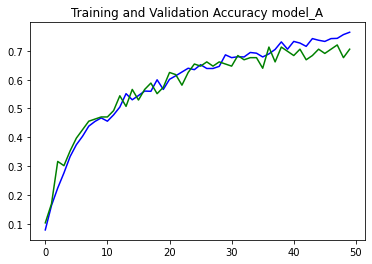

In [82]:
# plot training accuracies
plt.plot(history_A.history['acc'],'b') #train acc
plt.plot(history_A.history['val_acc'],'g') #val acc
plt.title('Training and Validation Accuracy model_A') 
plt.show()

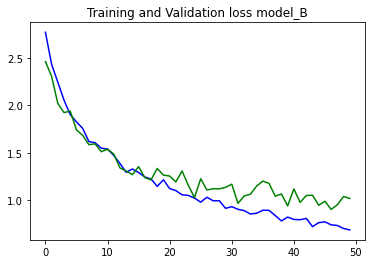

In [83]:
# plot training and validation loss
plt.plot(history_A.history['loss'],'b') #train loss
plt.plot(history_A.history['val_loss'],'g') #val loss
plt.title('Training and Validation loss model_B') 
plt.show()

In [85]:
modelb = Sequential()

# Input layer and 2D Con
modelb.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
modelb.add(layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
modelb.add(layers.BatchNormalization())

# 2D Convolution layer
modelb.add(layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
modelb.add(layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
modelb.add(layers.BatchNormalization())

# 2D Convolution layer
modelb.add(layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
modelb.add(layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
modelb.add(layers.BatchNormalization())

# 2D Convolution layer
modelb.add(layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
modelb.add(layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
modelb.add(layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
modelb.add(layers.Flatten())

modelb.add(layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
modelb.add(layers.Dropout(0.2))
modelb.add(layers.Dense(64, activation='relu'))

# Normalization layer
modelb.add(layers.BatchNormalization())

#Add Output Layer
modelb.add(layers.Dense(17, activation='softmax')) # = 12 predicted classes

modelb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_B = modelb
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)      

In [86]:
t0=time.time()
history_B = model_B.fit_generator(datagen.flow(trainX, trainY, batch_size=50), epochs=50, validation_data=(testX, testY), verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores = model_B.evaluate(testX, testY, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25/25 - 16s - loss: 2.4708 - acc: 0.2255 - val_loss: 2.7983 - val_acc: 0.0956
Epoch 2/50
25/25 - 14s - loss: 1.9697 - acc: 0.3521 - val_loss: 2.8327 - val_acc: 0.0588
Epoch 3/50
25/25 - 15s - loss: 1.6946 - acc: 0.4387 - val_loss: 2.9386 - val_acc: 0.0662
Epoch 4/50
25/25 - 15s - loss: 1.5019 - acc: 0.4918 - val_loss: 3.0203 - val_acc: 0.0809
Epoch 5/50
25/25 - 14s - loss: 1.3911 - acc: 0.5458 - val_loss: 3.1316 - val_acc: 0.0588
Epoch 6/50
25/25 - 14s - loss: 1.3482 - acc: 0.5327 - val_loss: 3.0230 - val_acc: 0.0662
Epoch 7/50
25/25 - 15s - loss: 1.2591 - acc: 0.5850 - val_loss: 3.3606 - val_acc: 0.0588
Epoch 8/50
25/25 - 14s - loss: 1.1552 - acc: 0.6364 - val_loss: 3.3528 - val_acc: 0.0588
Epoch 9/50
25/25 - 14s - loss: 1.0833 - acc: 0.6675 - val_loss: 3.9311 - val_acc: 0.0662
Epoch 10/50
25/25 - 15s - loss: 1.0354 - acc: 0.6642 - val_loss: 3.3666 - val_acc: 0.0882
Epoch 11/50
25/25 - 14s - loss: 1.0019 - acc: 0.6577 - val_loss: 3.3251 - val_acc: 0.0882
Epoch 12/50
25/25 - 14s - loss

In [87]:
print(model_B.evaluate(trainX, trainY))  # Evaluate on train set
print(model_B.evaluate(testX, testY))  # Evaluate on test set

[0.36942650932891696, 0.874183]
[0.9756536343518425, 0.74264705]


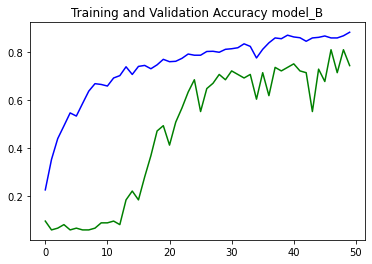

In [88]:
# plot training accuracies
plt.plot(history_B.history['acc'],'b') #train acc
plt.plot(history_B.history['val_acc'],'g') #val acc
plt.title('Training and Validation Accuracy model_B') 
plt.show()

In [89]:
model1 = Sequential()
model1.add(Flatten())
model1.add(Dense(128, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(17, activation="softmax"))

# Compile the model
model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
model1 = model1.fit(x=trainX, y=trainY, batch_size=32, epochs=35, validation_data=(testX, testY))

Train on 1224 samples, validate on 136 samples
Epoch 1/35
1224/1224 [==============================] - 1s 525us/sample - loss: 2.8764 - acc: 0.1127 - val_loss: 2.4187 - val_acc: 0.2647
Epoch 2/35
 160/1224 [==>...........................] - ETA: 0s - loss: 2.4226 - acc: 0.1875

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1224/1224 [==============================] - 1s 410us/sample - loss: 2.1966 - acc: 0.2459 - val_loss: 2.1193 - val_acc: 0.2647
Epoch 3/35
1224/1224 [==============================] - 0s 403us/sample - loss: 1.9405 - acc: 0.3292 - val_loss: 1.8915 - val_acc: 0.3162
Epoch 4/35
1224/1224 [==============================] - 0s 400us/sample - loss: 1.7340 - acc: 0.4126 - val_loss: 1.8091 - val_acc: 0.3529
Epoch 5/35
1224/1224 [==============================] - 1s 410us/sample - loss: 1.4483 - acc: 0.4910 - val_loss: 1.7917 - val_acc: 0.3971
Epoch 6/35
1224/1224 [==============================] - 1s 411us/sample - loss: 1.2882 - acc: 0.5482 - val_loss: 1.7349 - val_acc: 0.4412
Epoch 7/35
1224/1224 [==============================] - 1s 419us/sample - loss: 1.2085 - acc: 0.5727 - val_loss: 2.3074 - val_acc: 0.3529
Epoch 8/35
1224/1224 [==============================] - 0s 402us/sample - loss: 1.1676 - acc: 0.5850 - val_loss: 1.5696 - val_acc: 0.4779
Epoch 9/35
1224/1224 [=======================

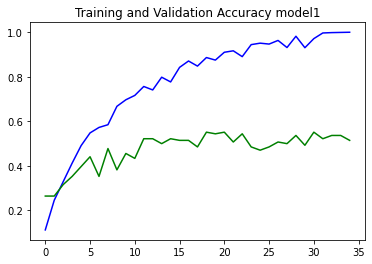

In [92]:
# plot training accuracies
plt.plot(model1.history['acc'],'b') #train acc
plt.plot(model1.history['val_acc'],'g') #val acc
plt.title('Training and Validation Accuracy model1') 
plt.show()